In [113]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

!pip install fuzzy-c-means

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
%matplotlib inline
from fcmeans import FCM
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt
from sklearn import metrics
#from pathlib import Path

In [4]:
directory_name = "gdrive/MyDrive/Colab Notebooks/GESTALT/"
objects_file = "data/output/ownershipAssignment/obj_df.csv"
locations_file = "data/output/ownershipAssignment/osm_df.csv"

In [61]:
objects_df = pd.read_csv(glob.glob(os.path.join(directory_name, objects_file))[0])
locations_df = pd.read_csv(glob.glob(os.path.join(directory_name, locations_file))[0], header=0)

In [6]:
objects_df = objects_df.drop(["color","type","length","surface","roof","shape","contents","material","style","size","species","cluster","predicted_location_dbscan","dbscan_correct"], axis=1)

In [120]:
def ownership_assignment(objects_df, locations_df):
    # Extract object locations
    # want [[1,2],[5,2],...]
    X = np.array(objects_df[["latitude","longitude"]].to_numpy())

    # Extract coordinates of locations to act as centroids
    locations = np.array(locations_df[["latitude","longitude"]].to_numpy())
    NUM_LOCS = len(locations)

    # Construct and train fuzzy c means
    fcm = FCM(n_clusters=NUM_LOCS)
    fcm.fit(X)

    # Force centroids to be known locations
    fcm._centers = locations

    # Use soft_predict to assign points to centroids with probabilities
    fcm_centers = fcm.centers
    fcm_labels = fcm.predict(X)
    fcm_matrix = fcm.soft_predict(X)

    return pd.DataFrame(fcm_matrix, index=objects_df['object'], columns=locations_df['location'])

In [ ]:
ownership_assignment(objects_df, locations_df)

In [123]:
# Extract object locations
# want [[1,2],[5,2],...]
X = np.array(objects_df[["latitude","longitude"]].to_numpy())

# Extract coordinates of locations to act as centroids
locations = np.array(locations_df[["latitude","longitude"]].to_numpy())
NUM_LOCS = len(locations)

# Construct and train fuzzy c means
fcm = FCM(n_clusters=NUM_LOCS)
fcm.fit(X)

# Force centroids to be known locations
fcm._centers = locations

# Use soft_predict to assign points to centroids with probabilities
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)
fcm_matrix = fcm.soft_predict(X)

In [35]:
actuals = np.array(objects_df['true_location'])

preds = []
for label in fcm_labels:
    preds.append(locations_df['location'][label].replace(" ","_").replace("'","").replace("_and_Café",""))

print(metrics.confusion_matrix(actuals, preds))
print(metrics.classification_report(actuals, preds, digits=3))  # for all classes predicted, which includes some not in the true locations
print(metrics.classification_report(actuals, preds, digits=3, labels=np.unique(actuals)))  # just for the true locations

[[18  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  1]
 [ 0  0  0 21  0  1  0  0]
 [ 0  3  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 28]]
                                  precision    recall  f1-score   support

                   Alis_Vineyard      1.000     1.000     1.000        18
Black_Swan_Winery_and_Restaurant      0.000     0.000     0.000         0
                  Faber_Vineyard      1.000     0.958     0.979        24
                 Lancaster_Wines      1.000     0.955     0.977        22
             Little_River_Winery      1.000     0.842     0.914        19
                   Nikola_Estate      0.000     0.000     0.000         0
                 Oakover_Grounds      1.000     1.000     1.000        35
             Ugly_Duckling_Wines      0.966     1.000     0.982        28

                        accuracy                          0.966       146
                       macro avg      0.7

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
true_locs = list(objects_df['true_location'].unique())

for i in range(len(true_locs)):
    true_locs[i] = true_locs[i].replace(" ","_").replace("'","").replace("_and_Café","")

clean_true_locs = ["Ali's Vineyard", 'Little River Winery and Café', 'Faber Vineyard', 'Ugly Duckling Wines', 'Oakover Grounds', 'Lancaster Wines']
centers_subset = locations_df[locations_df['location'].isin(clean_true_locs)][['latitude','longitude']].values

array([[116.000888, -31.824124],
       [115.988887, -31.85226 ],
       [116.007327, -31.84508 ],
       [116.01822 , -31.814194],
       [116.045655, -31.796771],
       [115.997425, -31.830502]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

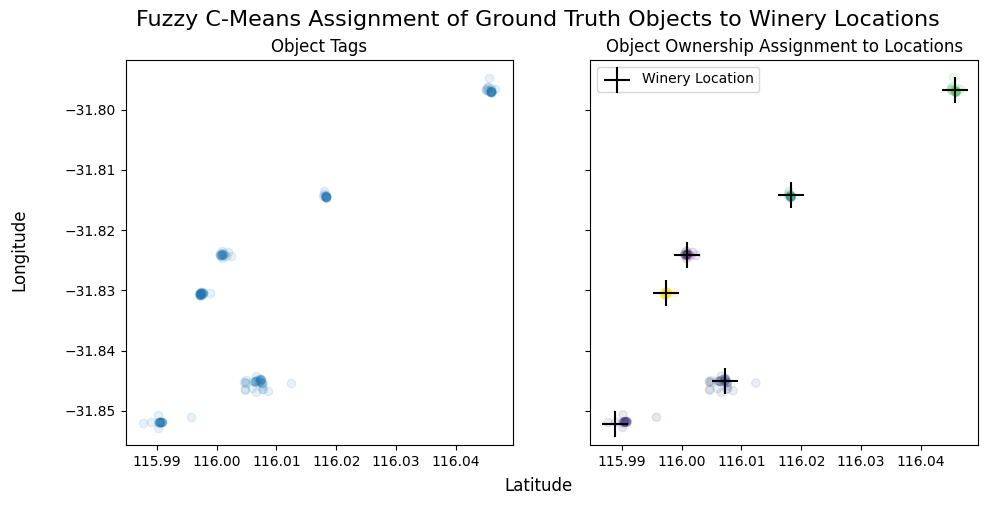

In [114]:
# plot result
fig, axes = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)
plt.ticklabel_format(useOffset=False)

axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
#axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='black')
axes[1].scatter(centers_subset[:,0], centers_subset[:,1], marker="+", s=350, c='black', label="Winery Location")

fig.supxlabel('Latitude')
fig.supylabel('Longitude')
fig.suptitle("Fuzzy C-Means Assignment of Ground Truth Objects to Winery Locations", fontsize=16)

axes[0].set_title('Object Tags')
axes[1].set_title('Object Ownership Assignment to Locations')
axes[1].legend()

plt.savefig("cluster_plt.png")
files.download("cluster_plt.png") 
plt.show()